In [1]:
!pip install torch --upgrade wandb

In [2]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import os
import torch
import random
import json
import datetime
import time
import wandb

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 

tqdm.pandas()

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: roanschellingerhout. Use `wandb login --relogin` to force relogin


True

In [4]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
skills = dict(zip(skills.index, skills.values))

In [6]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
certs = dict(zip(certs.index, certs.values))

In [8]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [9]:
licenses = dict(zip(licenses.index, licenses.values))

In [10]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
languages = dict(zip(languages.index, languages.values))

In [12]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,91
84612,49
84731,3773
85437,3819
85627,1560


In [13]:
addresses = dict(zip(addresses.index, addresses.values))

In [14]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [15]:
df_pred = pd.read_csv("../Data/df_pred_ext.csv").drop(["Unnamed: 0"], axis=1)

In [16]:
df_pred = df_pred.drop(["time_between", "job_order", "source"], axis=1)

In [17]:
# df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()

In [18]:
df_pred.head()

,candidate_id,time_spent,isco_functie_niveau,education,company_name,function_id,isco_code4
0,84556,-0.210459,2.0,0.0,324258,936,208
1,84556,-0.252626,1.0,0.0,324258,809,348
2,84556,-0.085012,2.0,0.0,329244,936,208
3,84556,-0.370694,1.0,0.0,368140,1519,344
4,84556,-0.363314,1.0,0.0,419826,1519,344


In [19]:
career_paths = df_pred.groupby("candidate_id")

In [20]:
candidate_lens = career_paths.apply(lambda x: len(x) - 1).to_dict()

In [21]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 6)

In [22]:
maximum_career_duration = 25

In [23]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:49<00:00, 9468.90it/s]


In [24]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [25]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [26]:
career_paths.head()

candidate_id
84556    [[-0.21045870102048395, 2.0, 0.0, 324258.0, 93...
84612    [[-0.3685852264755267, 1.0, 0.0, 201740.0, 151...
84731    [[-0.35066422025728855, 1.0, 0.0, 353745.0, 15...
85437    [[0.3313881928721292, 1.0, 2.0, 5500.0, 1519.0...
85888    [[-0.2895219637480053, 2.0, 3.0, 423330.0, 795...
dtype: object

In [27]:
idxs = []
x = []
y = []

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):       
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [28]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [29]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [30]:
del df_pred
del x

In [31]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [32]:
len(to_fill), len(y)

(113724, 113724)

In [33]:
# to_fill = to_fill[:75000]
# y = y[:75000]

In [34]:
def create_loaders(to_fill, idxs, y, split_size=0.8, weight_type=3, batch_size=512):

    # Train test split
    split = split_size

    training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
    test = np.array(list(set(range(len(to_fill))) - set(training)))

    train_indices, val_indices = idxs[training], idxs[test]
    X_train, X_val = to_fill[training], to_fill[test]
    y_train, y_val = y[training].astype(int), y[test].astype(int)

    # Class weights
    counts = (np.bincount(y_train) + 1)
    
    if weight_type == 1:
        labels_weights = 1. / counts
    elif weight_type == 2:
        labels_weights = 1. / np.sqrt(counts)
    elif weight_type == 3:
        labels_weights = 2. / (0.5 * np.sqrt(counts))
    else:
        return NotImplemented
        
    weights = labels_weights[y_train]
    sampler = WeightedRandomSampler(weights, len(weights))

    # Create dataloaders
    train_data = TensorDataset(torch.Tensor(train_indices), 
                               torch.Tensor(X_train), 
                               torch.Tensor(y_train).type(torch.LongTensor))

    trainloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

    val_data = TensorDataset(torch.Tensor(val_indices),
                             torch.Tensor(X_val),
                             torch.Tensor(y_val).type(torch.LongTensor))

    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    return trainloader, valloader

In [35]:
class CNN_LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, 
                 kernel_size, kernel_size2, F1, F2, dropout, 
                 num_layers, skills, certs, licenses, languages, 
                 addresses, w2v, candidate_lengths, max_len, 
                 skill_embedding_size=50, certs_embedding_size=20,
                 license_embedding_size=3, language_embedding_size=10,
                 address_embedding_size=25, function_embedding_size=50, 
                 isco4_embedding_size=25, education_embedding_size=3, 
                 isco_level_embedding_size=3, company_embedding_size=50):
        
        super(CNN_LSTM, self).__init__()
              
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size + 300
        self.hidden_size = hidden_size
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        
        # Address embedding
        self.address_embedding = nn.Embedding(4768, address_embedding_size)       
        
        # Categorical feature embeddings isco_functie_niveau	source	education	company_name	function_id	isco_code4
        self.function_embedding = nn.Embedding(2992, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
                
        # -5 --> embedded features get replaced
        N = self.input_size - 5 + skill_embedding_size + certs_embedding_size + \
            license_embedding_size + language_embedding_size + address_embedding_size + \
            function_embedding_size + isco4_embedding_size + company_embedding_size + \
            education_embedding_size + isco_level_embedding_size
                
        self.conv_padding = nn.ZeroPad2d((0, 0,
                                          kernel_size // 2, (kernel_size - 1) // 2))
        
        self.conv32 = nn.Conv2d(in_channels=1,
                                out_channels=F1,
                                kernel_size=(kernel_size, 1), 
                                stride=1)
        
        self.conv64 = nn.Conv2d(in_channels=F1, 
                                out_channels=F2,
                                kernel_size=(kernel_size, 1), 
                                stride=1)
        
        self.avgpooling = nn.AvgPool3d(kernel_size=(F2, 1, kernel_size2))
        
        self.dropout = nn.Dropout(p=dropout)
            
        self.lstm = nn.LSTM(input_size=N // kernel_size2,
                            hidden_size=hidden_size,
                            num_layers=1,
                            batch_first=True)
            
        # Final fully-connected layer takes the LSTM output, as well as the static embeddings
        self.fc = nn.Linear(hidden_size, num_classes)
        
        self.softmax = nn.LogSoftmax(dim=-1)

        # Skill lookup
        self.skills = skills
        
        # Certificate lookup
        self.certs = certs
        
        # License lookup
        self.licenses = licenses
        
        # Language lookup
        self.langs = languages
        
        # Address lookup
        self.adds = addresses
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len      
        
        def get_from_dict(x, cdict, N):
            return cdict.get(x, np.zeros((N,)))

        self.retrieve_static = np.vectorize(get_from_dict, otypes=[np.ndarray])  
                
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        actual_career_duration = career_duration
        career_duration = min(career_duration, max_len)
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.LongTensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                
                to_skip = 0
                                
                # Make sure to use candidates' most recent max_len cvs
                if actual_career_duration > self.max_len:
                    # 0, 10, 20, 30, 40, 50
                    # duration = 50
                    # ---> 0, 5, 15, 25
                                        
                    # Update to only include most recent max_len
                    ks -= max_len
                    
                    # Drop everything older than max_len time steps
                    ks_2 = np.array([ks[i] for i in range(len(ks)) if i < len(ks) and (i + 1 >= len(ks) or ks[i + 1] > 0)])
                    
                    # Store how many we need to skip while indexing
                    to_skip = len(ks) - len(ks_2)
                    
                    # Update ks
                    ks = ks_2
                    ks[0] = 0
                    
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= min(self.max_len, career_duration)])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        # Figure out negative duration cause
                        storage.append(torch.stack([torch.Tensor(embed_values[i + to_skip])] * duration, dim=0))
                else:
                    w2v_list = torch.LongTensor(cvs[0]).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * 300).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
 
    def forward(self, candidate, x):               
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * 500).type(torch.LongTensor).to(device)
        
        candidate_features = []
        
        skill_list = self.retrieve_static(candidate, self.skills, 317)
        skill_list = torch.LongTensor(np.stack(skill_list)).to(device)
        
        certs_list = self.retrieve_static(candidate, self.certs, 98)
        certs_list = torch.LongTensor(np.stack(certs_list)).to(device)
        
        license_list = self.retrieve_static(candidate, self.licenses, 8)
        license_list = torch.LongTensor(np.stack(license_list)).to(device)
        
        langs_list = self.retrieve_static(candidate, self.langs, 23)
        langs_list = torch.LongTensor(np.stack(langs_list)).to(device)
            
        address = self.retrieve_static(candidate, self.adds, 1)
        address = torch.LongTensor(np.stack(address)).to(device)
        
        # Embed every static feature
        skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                            self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                            self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                            self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
        
        # Combine and embed
        batch_features = torch.cat([skill_list, certs_list, 
                                    license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
        batch_addresses = self.address_embedding(address)[:,0,:]
                
        # For each candidate in the current batch
        for i, c in enumerate(candidate):
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]
                        
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)
            
            # Reset to max_len
            career_duration = min(career_duration, max_len)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([feature_width] * (self.max_len - career_duration))
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                   
            # Broadcast and add static features
            static_features = torch.stack([batch_features[i]] * career_duration).type(torch.LongTensor).to(device)
            address_emb = torch.stack([batch_addresses[i]] * career_duration).type(torch.LongTensor).to(device)
            
            # Combine w2v, static features, and address
            full_features = torch.cat([w2v_list, static_features, address_emb], dim=1)
                                    
            # Broadcast CV, static, and address to the correct length
            full_features = torch.cat([zeros, full_features], dim=0)
                    
            # Store result
            candidate_features.append(full_features)
                                
        # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
                
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, education, company_name, function_id, isco_code = [x[:,:,-5],
                                                                       x[:,:,-4],
                                                                       x[:,:,-3],
                                                                       x[:,:,-2],
                                                                       x[:,:,-1]]
        
        x = x[:,:,:-5].to(device)
        
        isco_level_smoothing = (isco_level != 0).unsqueeze(-1)
        education_smoothing = (education != 0).unsqueeze(-1)
        company_name_smoothing = (company_name != 0).unsqueeze(-1)
        function_id_smoothing = (function_id != 0).unsqueeze(-1)
        isco_code_smoothing = (isco_code != 0).unsqueeze(-1)
                
        isco_level, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)) * isco_level_smoothing,
                                                                        self.education_embedding(education.type(torch.LongTensor).to(device)) * education_smoothing,
                                                                        self.company_embedding(company_name.type(torch.LongTensor).to(device)) * company_name_smoothing,
                                                                        self.function_embedding(function_id.type(torch.LongTensor).to(device)) * function_id_smoothing,
                                                                        self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device)) * isco_code_smoothing]   
                
        # Add features
        x = torch.cat([x, isco_level, education, company_name, function_id, isco_code, additional_features], dim=2)
        x = x.unsqueeze(1)
                                       
        # Forward pass
        x = self.conv_padding(x)
        x = self.conv32(x)
        x = self.conv_padding(x)
        x = self.conv64(x)
                
        # Apply maxpooling
        x = self.avgpooling(x)
                                            
        # Get rid of extra dimension
        x = x.squeeze(1)
        
        x = self.dropout(x)
            
        _, (h_n, _) = self.lstm(x)
        
        x = h_n.squeeze(0)
        
        x = self.dropout(x)
        
        # Fully-connected
        out = self.fc(x)
    
        # softmax
        out = self.softmax(out)
                        
        return out

In [36]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    highest_performance = 0
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0

        for i, (candidate, career, job) in enumerate(trainloader):
            
            career, job = career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs = model(candidate, career)
                        
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
               
        training_loss /= len(trainloader)
                
        stats = test_loop(valloader, model, criterion)
        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        results["training_loss"].append(training_loss)
        
        if stats[0] > highest_performance:
            torch.save(model.state_dict(), "../models/CNN-LSTM_3.pt")
            highest_performance = stats[0]
            
        wandb.log({"test loss": stats[4],
                   "training loss": training_loss,
                   "test accuracy": stats[0] * 100})

        scheduler.step()
        
        done = int(time.time() - start)        
        print(f"Epoch duration: {int(done // 60)}:{int(done % 60):02d}")
        
        with open(f"../logs/CNN-LSTM/{datetime.now().strftime('%Y_%d_%m_%H:%M:%S')}.txt", "w+") as f:
            f.write(f"{model}\n\nEpoch: {epoch + 1}\n\nAcc@1: {stats[0]}\n\nDuration: {int(done // 60)}:{int(done % 60):02d}")
        
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
        
#         plt.plot(passed, training_losses, label="Training Loss")
#         plt.plot(passed, test_losses, label="Test Loss")
#         plt.xlabel("Epoch")
#         plt.ylabel("Average loss")
#         plt.legend()
#         plt.show()
                
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            career, job = career.to(device), job.to(device)
            pred = model(candidate, career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
            
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}")
    
    return acc1, acc5, acc10, acc20, test_loss

In [37]:
torch.cuda.empty_cache()

In [ ]:
num_epochs = 3
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-2, 1e-3, 1e-4][1:2]
hidden_sizes = [1000, 1500]
num_layerss = [1]
batch_sizes = [128, 256, 512][1:2]
kernel_sizes = [1, 2, 4]
kernel_sizes2 = [1, 2, 4]
F1_sizes = [32, 64, 128][:1]
F2_sizes = [64, 128, 256][:1]
dropout_probs = [0, 0.25, 0.5][:2]

skill_embedding_size=100
certs_embedding_size=50
license_embedding_size=10
language_embedding_size=15
address_embedding_size=25
function_embedding_size=250
isco4_embedding_size=150
education_embedding_size=10
isco_level_embedding_size=10
company_embedding_size=300
w2v_embedding_size = 300

try:            
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for num_layers in num_layerss:
                for hidden_size in hidden_sizes:
                    for kernel_size in kernel_sizes:
                        for kernel_size2 in kernel_sizes2:
                            for F1 in F1_sizes:
                                for F2 in F2_sizes:
                                    for dropout in dropout_probs:


                                        lstm = CNN_LSTM(num_classes=num_classes,
                                                        input_size=num_features,
                                                        num_layers=num_layers,
                                                        hidden_size=hidden_size,
                                                        kernel_size=kernel_size,
                                                        kernel_size2=kernel_size2,
                                                        F1=F1,
                                                        F2=F2,
                                                        dropout=dropout,
                                                        skills=skills, 
                                                        certs=certs,
                                                        licenses=licenses,
                                                        languages=languages,
                                                        addresses=addresses,
                                                        w2v=w2v,
                                                        skill_embedding_size=skill_embedding_size,
                                                        certs_embedding_size=certs_embedding_size,
                                                        license_embedding_size=license_embedding_size,
                                                        language_embedding_size=language_embedding_size,
                                                        address_embedding_size=address_embedding_size,
                                                        function_embedding_size=function_embedding_size,
                                                        isco4_embedding_size=isco4_embedding_size,
                                                        education_embedding_size=education_embedding_size,
                                                        isco_level_embedding_size=isco_level_embedding_size,
                                                        company_embedding_size=company_embedding_size,
                                                        candidate_lengths=candidate_lens,
                                                        max_len=max_len)

                                        lstm = lstm.to(device)

                                        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
                                        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

                                        total = len(learning_rates) * len(num_layerss) * len(hidden_sizes) * len(batch_sizes) *\
                                                len(kernel_sizes) * len(kernel_sizes2) * len(F1_sizes) * len(F2_sizes) * len(dropout_probs)

                                        print(f"Current iteration {current}/{total}")
                                        print(f"- Initial learning rate: {learning_rate}\n- Model: \n\n", lstm, "\n")



                                        wandb.init(project="CNN-LSTM", entity="roanschellingerhout", config= {"learning_rate": learning_rate,
                                                                                                              "epochs": 3,
                                                                                                              "batch_size": batch_size,
                                                                                                              "F1_size": F1,
                                                                                                              "F2_size": F2,
                                                                                                              "kernel_size": kernel_size,
                                                                                                              "kernel_size2": kernel_size2,
                                                                                                              "hidden_size": hidden_size,
                                                                                                              "num_layers":num_layers,
                                                                                                              "dropout": dropout})

                                        trainloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                                                                weight_type=3, batch_size=batch_size)

                                        # Store results of current configuration
                                        outcome = train_loop(lstm, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
                                        outcome["lr"] = [learning_rate] * num_epochs
                                        outcome["Batch size"] = [batch_size] * num_epochs
                                        outcome["Number of layers"] = [num_layers] * num_epochs
                                        outcome["Nodes per layer"] = [hidden_size] * num_epochs
                                        outcome["Kernel size"] = [kernel_size] * num_epochs
                                        outcome["Kernel size 2"] = [kernel_size2] * num_epochs
                                        outcome["F1 size"] = [F1] * num_epochs
                                        outcome["F2 size"] = [F2] * num_epochs
                                        outcome["Dropout"] = [dropout] * num_epochs

                                        full_results.append(outcome)

                                        with open("../results/CNN-LSTM.json", "w") as current_stats:
                                            json.dump(full_results, current_stats)

                                        current += 1
except KeyboardInterrupt:
    pass

Current iteration 0/36
- Initial learning rate: 0.001
- Model: 

 CNN_LSTM(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2992, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (conv_padding): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
  (conv32): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv64): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (avgpooling): AvgPool3d(kernel_size=(64, 1, 1), stride=(64, 1, 1), padding=0)
  (dropout): Dropout(p=0, inplace=False)
  (lstm): LSTM(1221, 1000, batch_first=True)
  (fc): Line

-------------------------------------------------------------------------------
Epoch starting at: 19:23:03
Epoch: 1, batch: 356/356, loss: 2.96665
Test Error:
Acc@1: 20.88%, Acc@5: 48.35%, Acc@10: 60.92%, Acc@20: 74.09% Avg loss: 3.553981
Epoch duration: 6:00
-------------------------------------------------------------------------------
Epoch starting at: 19:29:04
Epoch: 2, batch: 356/356, loss: 1.55602
Test Error:
Acc@1: 21.68%, Acc@5: 50.39%, Acc@10: 63.63%, Acc@20: 76.38% Avg loss: 3.512354
Epoch duration: 6:00
-------------------------------------------------------------------------------
Epoch starting at: 19:35:04
Epoch: 3, batch: 356/356, loss: 1.03856
Test Error:
Acc@1: 22.78%, Acc@5: 51.70%, Acc@10: 65.00%, Acc@20: 77.08% Avg loss: 3.549529
Epoch duration: 6:01
Current iteration 1/36
- Initial learning rate: 0.001
- Model: 

 CNN_LSTM(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=

test accuracy,▁▄█
test loss,█▁▇
training loss,█▃▁
test accuracy,22.77863
test loss,3.54953
training loss,1.36234


-------------------------------------------------------------------------------
Epoch starting at: 19:41:19
Epoch: 1, batch: 356/356, loss: 3.31916
Test Error:
Acc@1: 22.28%, Acc@5: 49.26%, Acc@10: 61.86%, Acc@20: 73.98% Avg loss: 3.562981
Epoch duration: 6:02
-------------------------------------------------------------------------------
Epoch starting at: 19:47:21


In [40]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Batch size", "Number of layers", "Nodes per layer", 
                                               "Kernel size", "F1 size", "F2 size", "Dropout", "Epoch"])

In [41]:
total

Acc@1  \
lr    Batch size Number of layers Nodes per layer Kernel size F1 size F2 size Dropout Epoch             
0.001 256        1                1000            1           32      64      0.00    1      0.208793   
                                                                                      2      0.216751   
                                                                                      3      0.227786   
                                                                              0.25    1      0.222818   
                                                                                      2      0.201143   
...                                                                                               ...   
                                  1500            4           32      64      0.00    2      0.191954   
                                                                                      3      0.197098   
                                                                              0.25    1      0.156122   
                                                                                      2      0.178061   
                                                                                      3      0.194284   

                                                                                                Acc@5  \
lr    Batch size Number of layers Nodes per layer Kernel size F1 size F2 size Dropout Epoch             
0.001 256        1                1000            1           32      64      0.00    1      0.483491   
                                                                                      2      0.503935   
                                                                                      3      0.516993   
                                                                              0.25    1      0.492636   
                                                                                      2      0.468587   
...                                                                                               ...   
                                  1500            4           32      64      0.00    2      0.478259   
                                                                                      3      0.488371   
                                                                              0.25    1      0.429985   
                                                                                      2      0.441240   
                                                                                      3      0.459881   

                                                                                               Acc@10  \
lr    Batch size Number of layers Nodes per layer Kernel size F1 size F2 size Dropout Epoch             
0.001 256        1                1000            1           32      64      0.00    1      0.609189   
                                                                                      2      0.636272   
                                                                                      3      0.649989   
                                                                              0.25    1      0.618641   
                                                                                      2      0.600440   
...                                                                                               ...   
                                  1500            4           32      64      0.00    2      0.622730   
                                                                                      3      0.629457   
                                                                              0.25    1      0.568213   
                                                                                      2      0.579072   
                                                                                      3      0.597450   

In [42]:
total.to_csv("../results/CNN-LSTM-results_2.csv")

Batch accuracy: 0.4140625
Previous-job baseline accuracy: 0.0
Fraction of previous job predictions: 0.0


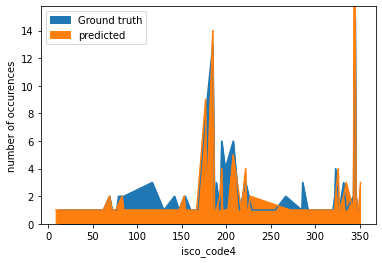

In [47]:
with torch.no_grad():
    for candidate, career, job in valloader:
        career, job = career.to(device), job.to(device)
        pred = lstm(candidate, career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())
        
        # Check how often the model predicted the previous job + compare to baseline performance
        previous_job = torch.Tensor(career_paths.loc[candidate.cpu()].apply(lambda x: x[-2][-1]).values).to(device)
        print("Previous-job baseline accuracy:", (job == previous_job).cpu().numpy().mean())
        print("Fraction of previous job predictions:", (pred.argmax(1) == previous_job).cpu().numpy().mean())
                
        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
        
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
        
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
        plt.show()
        
        break